# About this kernel

The goal is to:
* Investigate the problem of null masks by exploring the distribution of NaN per image.
* Reduce image size to 224x224 for simpler models.
* Create a lightweight CNN to predict if a certain image has no defect (i.e., it has 4 missing masks). This will be useful in order to reduce the computation power needed to train a segmentation model (e.g. Mask R-CNN), since we can immediately discard the image with 4 missing masks.

This is a work in progress, and I will update the kernel in the next few days. I'll work hard on this if you show some support :)

### Updates
* V9: Changed model from MobileNet to DenseNet.

In [1]:
import os
import json

import cv2
import numpy as np
import pandas as pd
import keras
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import tensorflow as tf
from tqdm import tqdm

Using TensorFlow backend.
C:\Users\Lam Family\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Lam Family\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Lam Family\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\La

In [3]:
train_df = pd.read_csv('./input/train.csv')

print(train_df.shape)
train_df.head()

(50272, 2)


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [4]:
submission_df = pd.read_csv('./input/sample_submission.csv')
print(submission_df.shape)
submission_df.head()

(7204, 2)


,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,1 1
1,004f40c73.jpg_2,1 1
2,004f40c73.jpg_3,1 1
3,004f40c73.jpg_4,1 1
4,006f39c41.jpg_1,1 1


In [5]:
unique_test_images = submission_df['ImageId_ClassId'].apply(
    lambda x: x.split('_')[0]
).unique()

unique_test_images

array(['004f40c73.jpg', '006f39c41.jpg', '00b7fb703.jpg', ...,
       'ffbf79783.jpg', 'ffc9a6187.jpg', 'ffdb60677.jpg'], dtype=object)

# EDA

This EDA will mainly focus on detecting how the null masks are distributed. We will group all the `ImageId_ClassId` by their respective ImageId, and keep track of the number of missing masks for each image.

In [6]:
train_df['isNan'] = pd.isna(train_df['EncodedPixels'])
train_df['ImageId'] = train_df['ImageId_ClassId'].apply(
    lambda x: x.split('_')[0]
)
train_df.head()

,ImageId_ClassId,EncodedPixels,isNan,ImageId
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,False,0002cc93b.jpg
1,0002cc93b.jpg_2,NaN,True,0002cc93b.jpg
2,0002cc93b.jpg_3,NaN,True,0002cc93b.jpg
3,0002cc93b.jpg_4,NaN,True,0002cc93b.jpg
4,00031f466.jpg_1,NaN,True,00031f466.jpg


In [7]:
train_nan_df = train_df.groupby(by='ImageId', axis=0).agg('sum')
train_nan_df.reset_index(inplace=True)
train_nan_df.rename(columns={'isNan': 'missingCount'}, inplace=True)
train_nan_df['missingCount'] = train_nan_df['missingCount'].astype(np.int32)
train_nan_df['allMissing'] = (train_nan_df['missingCount'] == 4).astype(int)

train_nan_df.head()

,ImageId,missingCount,allMissing
0,0002cc93b.jpg,3,0
1,00031f466.jpg,4,1
2,000418bfc.jpg,4,1
3,000789191.jpg,4,1
4,0007a71bf.jpg,3,0


In [8]:
test_nan_df = pd.DataFrame(unique_test_images, columns=['ImageId'])
print(test_nan_df.shape)
test_nan_df.head()

(1801, 1)


,ImageId
0,004f40c73.jpg
1,006f39c41.jpg
2,00b7fb703.jpg
3,00bbcd9af.jpg
4,0108ce457.jpg


In [9]:
train_nan_df['missingCount'].hist()
train_nan_df['missingCount'].value_counts()

3    6239
4    5902
2     425
1       2
Name: missingCount, dtype: int64

We notice that an overwhelming number of images have 3 to 4 missing masks. In fact, all except 2 images have 2+ missing masks. This means that we would basically need to train the final segmentation model on less than half of the data points.

# Reducing Image Size

In [10]:
def load_img(code, base, resize=True):
    path = f'{base}/{code}'
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if resize:
        img = cv2.resize(img, (256, 256))
    
    return img

def validate_path(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [13]:
train_path = './tmp/train'
validate_path(train_path)

for code in tqdm(train_nan_df['ImageId']):
    img = load_img(
        code,
        base='./input/train_images'
    )
    path = code.replace('.jpg', '')
    cv2.imwrite(f'{train_path}/{path}.png', img)


  8%|██▉                                   | 977/12568 [00:12<02:17, 84.38it/s]


 16%|█████▊                               | 1965/12568 [00:26<03:05, 57.07it/s]


 23%|████████▋                            | 2943/12568 [00:39<01:44, 92.22it/s]


 31%|███████████▍                         | 3895/12568 [00:52<03:21, 43.05it/s]


 38%|██████████████▏                      | 4838/12568 [01:05<01:24, 92.00it/s]


 46%|█████████████████                    | 5802/12568 [01:19<01:36, 70.47it/s]


 54%|███████████████████▊                 | 6732/12568 [01:33<01:36, 60.24it/s]


 61%|██████████████████████▋              | 7692/12568 [01:46<00:54, 90.29it/s]


 69%|█████████████████████████▍           | 8632/12568 [02:00<00:46, 84.27it/s]


 76%|████████████████████████████▏        | 9591/12568 [02:13<00:33, 87.62it/s]


 84%|██████████████████████████████▏     | 10544/12568 [02:27<00:22, 89.98it/s]


 91%|████████████████████████████████▉   | 11498/12568 [02:40<00:12, 83.54it/s]


 99%|███████████████████████████████████▌| 12412/12568 [02:53<00:04, 37.06it/s]


100%|████████████████████████████████████| 12568/12568 [02:56<00:00, 71.37it/s]


In [11]:
train_nan_df['ImageId'] = train_nan_df['ImageId'].apply(
    lambda x: x.replace('.jpg', '.png')
)

# Modelling

In [12]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.1,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,
        rotation_range=10,
        height_shift_range=0.1,
        width_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1/255.,
        validation_split=0.15
    )

def create_test_gen():
    return ImageDataGenerator(rescale=1/255.).flow_from_dataframe(
        test_nan_df,
        directory='../input/severstal-steel-defect-detection/test_images/',
        x_col='ImageId',
        class_mode=None,
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

def create_flow(datagen, subset):
    return datagen.flow_from_dataframe(
        train_nan_df, 
        directory='../tmp/train',
        x_col='ImageId', 
        y_col='allMissing', 
        class_mode='other',
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        subset=subset
    )

# Using original generator
data_generator = create_datagen()
train_gen = create_flow(data_generator, 'training')   #train set  10683
val_gen = create_flow(data_generator, 'validation')   #val set    1885
test_gen = create_test_gen()                          #test set   1801

Found 10683 validated image filenames.
Found 1885 validated image filenames.
Found 1801 validated image filenames.


In [13]:
def build_model():
    densenet = DenseNet121(
        include_top=False,
        input_shape=(256,256,3),
        weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5'
    )
    
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(5e-5),
        metrics=['accuracy']
    )
    
    return model

In [14]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

In [15]:
total_steps = train_nan_df.shape[0] / BATCH_SIZE

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    verbose=1,
    min_lr=1e-6
)

history = model.fit_generator(
    train_gen,
    steps_per_epoch=total_steps * 0.85,
    validation_data=val_gen,
    validation_steps=total_steps * 0.15,
    epochs=40,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/40
334/333 [==============================] - 254s 761ms/step - loss: 0.5646 - acc: 0.7541 - val_loss: 0.3469 - val_acc: 0.8462

Epoch 00001: val_acc improved from -inf to 0.84615, saving model to model.h5
Epoch 2/40
334/333 [==============================] - 205s 615ms/step - loss: 0.3461 - acc: 0.8598 - val_loss: 0.2417 - val_acc: 0.8950

Epoch 00002: val_acc improved from 0.84615 to 0.89496, saving model to model.h5
Epoch 3/40
334/333 [==============================] - 207s 620ms/step - loss: 0.2931 - acc: 0.8848 - val_loss: 0.2882 - val_acc: 0.8748

Epoch 00003: val_acc did not improve from 0.89496
Epoch 4/40
334/333 [==============================] - 209s 626ms/step - loss: 0.2564 - acc: 0.8978 - val_loss: 0.2263 - val_acc: 0.9114

Epoch 00004: val_acc improved from 0.89496 to 0.91141, saving model to model.h5
Epoch 5/40
334/333 [==============================] - 210s 629ms/step - loss: 0.2283 - acc: 0.9105 - val_loss: 0.2061 - val_acc: 0.9172

Epoch 00005: val_acc improve

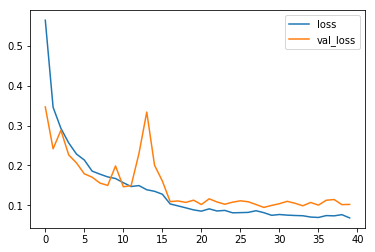

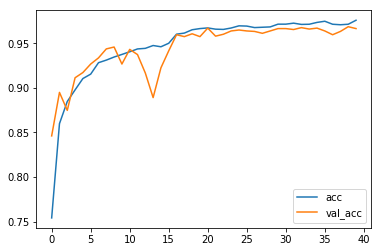

In [16]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

## Save results as CSV files

In [17]:
model.load_weights('model.h5')
y_test = model.predict_generator(
    test_gen,
    steps=len(test_gen),
    verbose=1
)

57/57 [==============================] - 18s 320ms/step


In [18]:
test_nan_df['allMissing'] = y_test

history_df.to_csv('history.csv', index=False)
train_nan_df.to_csv('train_missing_count.csv', index=False)
test_nan_df.to_csv('test_missing_count.csv', index=False)